In [1]:
%env LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
%env LLM_API_KEY=<替换为自己的key>

env: LLM_BASE_URL=https://dashscope.aliyuncs.com/compatible-mode/v1
env: LLM_API_KEY=<替换为自己的key>


In [36]:
%%capture --no-stderr
!pip install -U langchain langchain_community langchain_openai pypdf sentence_transformers chromadb shutil openpyxl rank_bm25 jieba

In [37]:
import langchain, langchain_community, pypdf, sentence_transformers, chromadb, langchain_core

for module in (langchain, langchain_core, langchain_community, pypdf, sentence_transformers, chromadb):
    print(f"{module.__name__:<30}{module.__version__}")

langchain                     0.2.10
langchain_core                0.2.28
langchain_community           0.2.9
pypdf                         4.3.1
sentence_transformers         3.0.1
chromadb                      0.5.4


In [38]:
import os
import pandas as pd

In [48]:
expr_version = 'retrieval_v4_bm25_hybrid'

preprocess_output_dir = os.path.join(os.path.pardir, 'outputs', 'v1_20240713')
expr_dir = os.path.join(os.path.pardir, 'experiments', expr_version)

# 读取文档

In [49]:
from langchain_community.document_loaders import PyPDFLoader

In [50]:
loader = PyPDFLoader(os.path.join(os.path.pardir, 'data', '2024全球经济金融展望报告.pdf'))
documents = loader.load()

qa_df = pd.read_excel(os.path.join(preprocess_output_dir, 'question_answer.xlsx'))

# 文档切分

In [51]:
from uuid import uuid4
import os
import pickle

from langchain.text_splitter import RecursiveCharacterTextSplitter

def split_docs(documents, filepath, chunk_size=400, chunk_overlap=40, seperators=['\n\n\n', '\n\n'], force_split=False):
    if os.path.exists(filepath) and not force_split:
        print('found cache, restoring...')
        return pickle.load(open(filepath, 'rb'))

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=seperators
    )
    split_docs = splitter.split_documents(documents)
    for chunk in split_docs:
        chunk.metadata['uuid'] = str(uuid4())

    pickle.dump(split_docs, open(filepath, 'wb'))

    return split_docs

In [52]:
splitted_docs = split_docs(documents, os.path.join(preprocess_output_dir, 'split_docs.pkl'), chunk_size=500, chunk_overlap=50)

found cache, restoring...


# 检索

In [53]:
from langchain.embeddings import HuggingFaceBgeEmbeddings
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

def get_embeddings(model_path):
    embeddings = HuggingFaceBgeEmbeddings(
        model_name=model_path,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': True},
        # show_progress=True
        query_instruction='为这个句子生成表示以用于检索相关文章：'
    )
    return embeddings

device: cuda


In [54]:
from tqdm.auto import tqdm
# from langchain_community.vectorstores import Qdrant
from langchain_community.vectorstores import Chroma
from langchain.retrievers import BM25Retriever, EnsembleRetriever
import jieba
import shutil

# 微调后的模型
EMBEDDING_MODEL_PATH = 'stevenluo/bge-large-zh-v1.5-ft-v4'

# 确保结果可复现性
persist_directory = os.path.join(expr_dir, 'chroma', 'bge')
shutil.rmtree(persist_directory, ignore_errors=True)

embeddings = get_embeddings(EMBEDDING_MODEL_PATH)
vector_db = Chroma.from_documents(
    splitted_docs,
    embedding=embeddings,
    persist_directory=persist_directory
)
vanilla_bm25_retriever = BM25Retriever.from_documents(splitted_docs)
chz_cut_bm25_retriever = BM25Retriever.from_documents(splitted_docs, preprocess_func=lambda text: list(jieba.cut(text)))

In [55]:
def get_emb_retriever(k):
    return vector_db.as_retriever(search_kwargs={'k': k})

def get_vanilla_bm25_retriever(k):
    vanilla_bm25_retriever.k = k
    return vanilla_bm25_retriever

def get_chz_cut_bm25_retriever(k):
    chz_cut_bm25_retriever.k = k
    return chz_cut_bm25_retriever

def build_get_ensemble_retriver_fn(weights=[0.5, 0.5]):
    def get_ensemble_retriever(k):
        chz_cut_bm25_retriever.k = k
        return EnsembleRetriever(
            retrievers=[vector_db.as_retriever(search_kwargs={'k': k}), chz_cut_bm25_retriever], weights=weights
        )
    return get_ensemble_retriever

In [56]:
test_df = qa_df[(qa_df['dataset'] == 'test') & (qa_df['qa_type'] == 'detailed')]

In [57]:
def get_hit_stat_df(get_retriever_fn, top_k_arr=list(range(1, 9))):
    hit_stat_data = []

    for k in tqdm(top_k_arr):
        retriever = get_retriever_fn(k)
        for idx, row in test_df.iterrows():
            question = row['question']
            true_uuid = row['uuid']
            # chunks = retrieve_fn(question, k=k)
            chunks = retriever.get_relevant_documents(question)[:k]
            retrieved_uuids = [doc.metadata['uuid'] for doc in chunks]

            hit_stat_data.append({
                'question': question,
                'top_k': k,
                'hit': int(true_uuid in retrieved_uuids),
                'retrieved_chunks': len(chunks)
            })
    hit_stat_df = pd.DataFrame(hit_stat_data)
    return hit_stat_df

## BM25检索

In [58]:
vanilla_bm25_hit_stat_df = get_hit_stat_df(get_vanilla_bm25_retriever)
chz_cut_bm25_hit_stat_df = get_hit_stat_df(get_chz_cut_bm25_retriever)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [59]:
vanilla_bm25_hit_stat_df['retriever'] = 'vanilla_bm25'
chz_cut_bm25_hit_stat_df['retriever'] = 'jieba_cut_bm25'

bm25_hit_stat_df = pd.concat([vanilla_bm25_hit_stat_df, chz_cut_bm25_hit_stat_df])

In [60]:
bm25_hit_stat_df.groupby(['retriever', 'top_k'])['hit'].mean().reset_index().rename(columns={'hit': 'hit_rate'})

,retriever,top_k,hit_rate
0,jieba_cut_bm25,1,0.666667
1,jieba_cut_bm25,2,0.784946
2,jieba_cut_bm25,3,0.838710
3,jieba_cut_bm25,4,0.870968
4,jieba_cut_bm25,5,0.892473
5,jieba_cut_bm25,6,0.903226
6,jieba_cut_bm25,7,0.913978
7,jieba_cut_bm25,8,0.935484
8,vanilla_bm25,1,0.000000
9,vanilla_bm25,2,0.000000


## Embedding检索

In [61]:
emb_hit_stat_df = get_hit_stat_df(get_emb_retriever)

  0%|          | 0/8 [00:00<?, ?it/s]

In [62]:
emb_hit_stat_df['retriever'] = 'embedding'

## Ensemble检索

In [63]:
ensemble_hit_stat_df_04_06 = get_hit_stat_df(build_get_ensemble_retriver_fn(weights=[0.4, 0.6]))
ensemble_hit_stat_df_05_05 = get_hit_stat_df(build_get_ensemble_retriver_fn(weights=[0.5, 0.5]))
ensemble_hit_stat_df_07_03 = get_hit_stat_df(build_get_ensemble_retriver_fn(weights=[0.7, 0.3]))
ensemble_hit_stat_df_09_01 = get_hit_stat_df(build_get_ensemble_retriver_fn(weights=[0.9, 0.1]))

ensemble_hit_stat_df_04_06['retriever'] = 'ensemble_0.4:0.6'
ensemble_hit_stat_df_05_05['retriever'] = 'ensemble_0.5:0.5'
ensemble_hit_stat_df_07_03['retriever'] = 'ensemble_0.7:0.3'
ensemble_hit_stat_df_09_01['retriever'] = 'ensemble_0.90.1'

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [64]:
ensemble_hit_stat_df = pd.concat([ensemble_hit_stat_df_04_06, ensemble_hit_stat_df_05_05, ensemble_hit_stat_df_07_03, ensemble_hit_stat_df_09_01])

In [65]:
ensemble_hit_stat_df.groupby(['retriever', 'top_k'])['hit'].mean().reset_index().rename(columns={'hit': 'hit_rate'})

,retriever,top_k,hit_rate
0,ensemble_0.4:0.6,1,0.666667
1,ensemble_0.4:0.6,2,0.784946
2,ensemble_0.4:0.6,3,0.838710
3,ensemble_0.4:0.6,4,0.870968
4,ensemble_0.4:0.6,5,0.892473
5,ensemble_0.4:0.6,6,0.903226
6,ensemble_0.4:0.6,7,0.913978
7,ensemble_0.4:0.6,8,0.935484
8,ensemble_0.5:0.5,1,0.548387
9,ensemble_0.5:0.5,2,0.774194


## 综合对比

In [66]:
hit_stat_df = pd.concat([chz_cut_bm25_hit_stat_df, emb_hit_stat_df, ensemble_hit_stat_df])

In [67]:
hit_stat_df.groupby(['retriever', 'top_k'])['hit'].mean().reset_index().rename(columns={'hit': 'hit_rate'})

,retriever,top_k,hit_rate
0,embedding,1,0.548387
1,embedding,2,0.698925
2,embedding,3,0.806452
3,embedding,4,0.870968
4,embedding,5,0.892473
5,embedding,6,0.903226
6,embedding,7,0.913978
7,embedding,8,0.935484
8,ensemble_0.4:0.6,1,0.666667
9,ensemble_0.4:0.6,2,0.784946


<Axes: xlabel='top_k', ylabel='hit'>

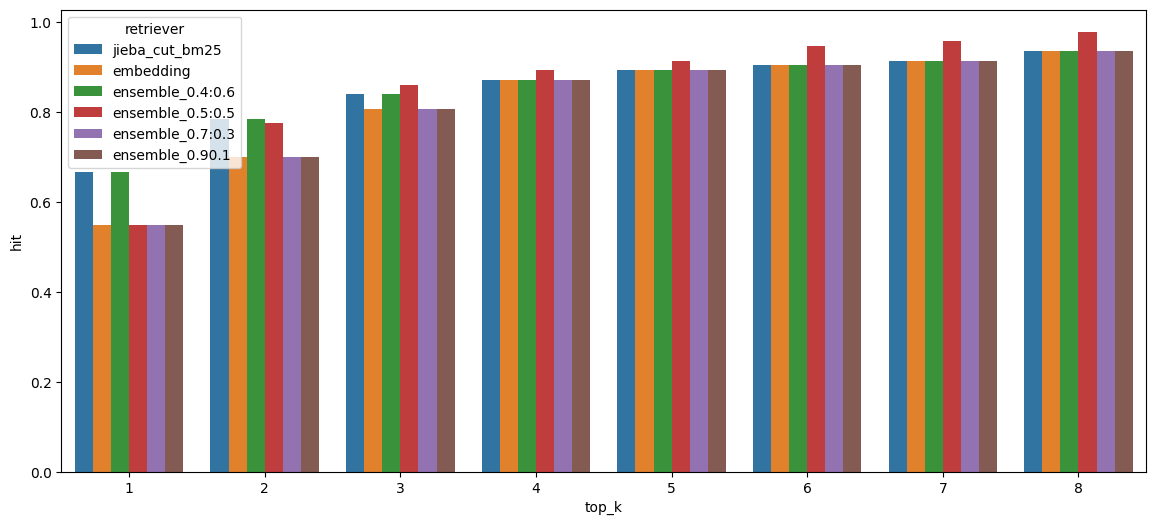

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.barplot(x='top_k', y='hit', hue='retriever', data=hit_stat_df, errorbar=None)

# 问答全流程

In [29]:
from langchain.llms import Ollama

llm = Ollama(
    model='qwen2:7b-instruct',
    base_url='http://localhost:11434'
)

In [30]:
llm.invoke('你是谁')

'我是阿里云开发的一款超大规模语言模型，我叫通义千问。作为一个AI助手，我的目标是帮助用户获得准确、有用的信息，解决他们的问题和困惑。无论是学术问题、技术难题、日常建议还是娱乐话题，我都尽力提供高质量的回答或辅助。请随时向我提问，我会努力提供最好的帮助！'

In [31]:
def rag(retriever, query, n_chunks=4):
    prompt_tmpl = """
你是一个金融分析师，擅长根据所获取的信息片段，对问题进行分析和推理。
你的任务是根据所获取的信息片段（<<<<context>>><<<</context>>>之间的内容）回答问题。
回答保持简洁，不必重复问题，不要添加描述性解释和与答案无关的任何内容。
已知信息：
<<<<context>>>
{{knowledge}}
<<<</context>>>

问题：{{query}}
请回答：
""".strip()

    # chunks = retrieve(vector_db, query, k=n_chunks)
    chunks = retriever.get_relevant_documents(query)[:n_chunks]
    prompt = prompt_tmpl.replace('{{knowledge}}', '\n\n'.join([doc.page_content for doc in chunks])).replace('{{query}}', query)

    return llm(prompt), chunks

In [32]:
n_chunks = 3

retriever = build_get_ensemble_retriver_fn(weights=[0.5, 0.5])(n_chunks)
print(rag(retriever, '2023年10月美国ISM制造业PMI指数较上月有何变化？')[0])

/opt/anaconda3/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


2023年10月美国ISM制造业PMI指数较上个月大幅下降了2.3个百分点。


## 预测

In [33]:
prediction_df = qa_df[qa_df['dataset'] == 'test'][['uuid', 'question', 'qa_type', 'answer']].rename(columns={'answer': 'ref_answer'})

def predict(prediction_df, retriever, n_chunks):
    prediction_df = prediction_df.copy()
    answer_dict = {}

    for idx, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        uuid = row['uuid']
        question = row['question']
        answer, chunks = rag(retriever, question, n_chunks=n_chunks)
        assert len(chunks) <= n_chunks
        answer_dict[question] = {
            'uuid': uuid,
            'ref_answer': row['ref_answer'],
            'gen_answer': answer,
            'chunks': chunks
        }
    prediction_df.loc[:, 'gen_answer'] = prediction_df['question'].apply(lambda q: answer_dict[q]['gen_answer'])
    prediction_df.loc[:, 'chunks'] = prediction_df['question'].apply(lambda q: answer_dict[q]['chunks'])

    return prediction_df

In [36]:
n_chunks = 3
retriver = build_get_ensemble_retriver_fn(weights=[0.5, 0.5])(n_chunks)
pred_df = predict(prediction_df, retriever, n_chunks=n_chunks)

  0%|          | 0/100 [00:00<?, ?it/s]

# 评估

In [42]:
from langchain_openai import ChatOpenAI
import time

judge_llm = ChatOpenAI(
    api_key=os.environ['LLM_API_KEY'],
    base_url=os.environ['LLM_BASE_URL'],
    model_name='qwen2-72b-instruct',
    temperature=0
)

def evaluate(prediction_df):
    """
    对预测结果进行打分
    :param prediction_df: 预测结果，需要包含问题，参考答案，生成的答案，列名分别为question, ref_answer, gen_answer
    :return 打分模型原始返回结果
    """
    prompt_tmpl = """
你是一个经济学博士，现在我有一系列问题，有一个助手已经对这些问题进行了回答，你需要参照参考答案，评价这个助手的回答是否正确，仅回复“是”或“否”即可，不要带其他描述性内容或无关信息。
问题：
<question>
{{question}}
</question>

参考答案：
<ref_answer>
{{ref_answer}}
</ref_answer>

助手回答：
<gen_answer>
{{gen_answer}}
</gen_answer>
请评价：
    """
    results = []

    for _, row in tqdm(prediction_df.iterrows(), total=len(prediction_df)):
        question = row['question']
        ref_answer = row['ref_answer']
        gen_answer = row['gen_answer']

        prompt = prompt_tmpl.replace('{{question}}', question).replace('{{ref_answer}}', str(ref_answer)).replace('{{gen_answer}}', gen_answer).strip()
        result = judge_llm.invoke(prompt).content
        results.append(result)

        time.sleep(1)
    return results

In [43]:
pred_df['raw_score'] = evaluate(pred_df)

  0%|          | 0/100 [00:00<?, ?it/s]

In [44]:
pred_df['raw_score'].unique()

array(['是', '否'], dtype=object)

In [45]:
# prediction_df['score'] = (prediction_df['raw_score'] == '是').astype(int)
pred_df.loc[:, 'score'] = pred_df['raw_score'].replace({'是': 1, '否': 0})
_ = pred_df.pop('raw_score')

/tmp/ipykernel_172348/3896259812.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pred_df.loc[:, 'score'] = pred_df['raw_score'].replace({'是': 1, '否': 0})


In [46]:
pred_df['score'].mean()

0.78

In [ ]:
pred_df.to_excel(os.path.join(expr_dir, 'prediction.xlsx'), index=False)